In [1]:
#DATA
#SKU - SKU NUmber
#Std. Price ($) - Price of each unit of SKU
#On-Hand Stock ($) - Total stock on-hand as of 30th Sep'20	 
#APU (units) - Average monthly consumption (30 days) of the SKU
#APU Trend - Anticipated APU trend provided by marketing (e.g. 50% indicates 50% increase in APU consumption)
#S-OTD - Supplier On-time delivery (S-OTD) performance for the past 12 months
#Demand variability (COV) - Demand Coefficient of variance for the past 12 months
#Lead Time (days) - Lead time in days to procure the SKU

#Assumptions to be taken into consideration:
# The Minimum Order Quantity (MOQ) is equal to one lead-time demand
# The service level targeted can be assumed to be 95%
# The expiry for all the mentioned SKUs is one year

#FIND THE FOLLOWING
# Estimate the change in the inventory position to understand the working capital impact  
# Based on the marketing insights gathered, understand the potential obsolete inventory that they currently have

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import special, stats
from itertools import islice 
import seaborn as sns

In [3]:
#getting data
xls = pd.ExcelFile('2021-ascm-case-competition_school-round_data-exhibits.xlsx')
df = pd.read_excel(xls, 'Data Exhibit-2')

print(list(df.columns))
print(df.dtypes)

['SKU ', 'Std. Price ($)', 'On-Hand Stock ($)', 'APU\n(units)', 'APU Trend', 'S-OTD', 'Demand variability (COV)', 'Lead Time (days)']
SKU                         float64
Std. Price ($)              float64
On-Hand Stock ($)           float64
APU\n(units)                  int64
APU Trend                   float64
S-OTD                       float64
Demand variability (COV)    float64
Lead Time (days)              int64
dtype: object


In [4]:
#Calculate the sum of a Geometric Progression
def sumOfGP(a, r, n):       
    sum = 0
    i = 0
    while i < n: 
        sum = sum + a 
        a = a * r 
        i = i + 1
    return sum

In [5]:
df['Yearly Demand'] = sumOfGP(df['APU\n(units)'] * (1 + df['APU Trend']), 1 + df['APU Trend'], 12)
df['Initial Inventory'] = df['On-Hand Stock ($)'] / df['Std. Price ($)']
df.head()

,SKU,Std. Price ($),On-Hand Stock ($),APU\n(units),APU Trend,S-OTD,Demand variability (COV),Lead Time (days),Yearly Demand,Initial Inventory
0,14171.732125,33.762953,5837.312718,122,-0.1,0.77,1.56,23,7.878924e+02,172.891058
1,52169.042825,12.089326,1532.719476,178,0.2,0.85,1.80,12,8.454395e+03,126.782877
2,72156.257446,11.756134,4562.334137,324,-0.4,0.77,1.38,21,4.849421e+02,388.081145
3,8954.076984,8.157692,4156.895262,414,0.5,0.70,1.99,15,1.599030e+05,509.567542
4,94785.831804,5.269414,587.585764,170,1.2,0.80,0.92,15,4.006164e+06,111.508758


In [6]:
#Calculate ROQ
Z_alpha = 1.645 #as service level is 95% http://www.math.armstrong.edu/statsonline/5/5.3.2.html

def ROQ(LT_demands, row):
    m_d = np.mean(LT_demands)
    s_d = m_d * df.at[row, 'Demand variability (COV)']
    
    m_l = df.at[row, 'Lead Time (days)'] * df.at[row, 'S-OTD']
    x_l = df.at[row, 'Lead Time (days)']     
    
    ##SOURCE: 
        #https://math.stackexchange.com/questions/2560644/calculate-z-score-given-probability-using-erfinv
        #https://www.wolframalpha.com/input/?i=normal+distribution
    ##VERIFICATION:
        #https://stattrek.com/online-calculator/normal.aspx
    z_l = -np.sqrt(2)*special.erfcinv(2*df.at[row, 'S-OTD'])
    s_l = (x_l - m_l)/ z_l
    
    expected_demand = 0
    for i in LT_demands:
        expected_demand += i
        
    safety_stock = Z_alpha * np.sqrt(m_l * s_d**2 + m_d**2 * s_l**2)
    
    return expected_demand + safety_stock, expected_demand, safety_stock

In [7]:
#Gathering monthly demand data for all SKUs
sku_monthly_demand = []
for row in range(0, len(df.index)):
    
    #Input GP data
    a = df.iloc[row]['APU\n(units)'] * (1 + df.iloc[row]['APU Trend'])
    r = 1 + df.iloc[row]['APU Trend']
    n = 12
    
    m_demand = []
    total = 0
    
    for i in range(0, n):
        m_demand.append(a*r**(i))
        total += m_demand[i]
    sku_monthly_demand.append(m_demand)

#pprint(sku_monthly_demand)

In [8]:
#Gathering daily demand data for all SKUs
sku_daily_demand = []
for row in range(0, len(df.index)):    
    demand = []
    
    for day in range(0, n*30):
        #Finding month for given day and its corresponding monthly demand
        m = int(day / 30)
        m_d = sku_monthly_demand[row][m]
    
        #ASSUMPTION: Linear Distribution of demand in a month - y = a + x*b
        # a (level) = previous month's last day demand
        if day in range(0, 30): 
            #for initial month a = APU / 30 (ASSUMPTION: Earlier it was Constant Distribution)
            a = df.iloc[row]['APU\n(units)'] / 30
        else:
            a = demand[(m * 30) - 1]
            
        # b (trend) = difference in month end demands / summation of days
        slope = (m_d - 30 * a) / (30 * 31 / 2)
        demand.append(((day+1) - 30 * (m)) * slope + a)
    
    sku_daily_demand.append(demand)

#pprint(sku_daily_demand)

In [9]:
#Calculate the number of days the order lot size shall satisfy demand
def DSD(lot_size, sku, current_day):
    days_satisfied = 0
    while(lot_size > 0):
        try:
            lot_size -= sku_daily_demand[sku][df.at[sku, 'Lead Time (days)'] + current_day + days_satisfied]
        except IndexError:
            break
        days_satisfied += 1
    return days_satisfied - 1

In [10]:
def LinearRegression(month_demand):
    answer = []
    
    months = np.arange(12)
    y_bar = np.mean(month_demand)
    x_bar = np.mean(months)
    
    Sxx = 0
    Syy = 0
    Sxy = 0
    for i in months:
        Sxx += (i - x_bar)**2
        Syy += (month_demand[i] - y_bar)**2
        Sxy += (i - x_bar)*(month_demand[i] - y_bar)
        
    b = Sxy / Sxx
    a = y_bar - b * x_bar
    
    for i in months:
        answer.append(a + b*i)
    
    return answer

In [11]:
#calculating obsolete inventory
obsolete_inventory = []
obsolete_sku = pd.DataFrame(np.empty((0, df.shape[1])))    
obsolete_sku.columns = df.columns

total_obsolete_inventory_safety_stock = 0 #Rohan's Insight
#hist_data = []

ObsoleteKPI = []

for i in range(len(df)):
    #Finding safety stock of SKUs
    _, _, ss = ROQ(LinearRegression(sku_monthly_demand[i]), i)
    
    #Condition for obsoletion
    if df.at[i, 'Initial Inventory'] > (df.at[i, 'Yearly Demand'] + ss): 
        obsolete_sku.loc[df.index[i]] = df.iloc[i]
        obsolete_inventory.append((df.at[i, 'Initial Inventory'] - df.at[i, 'Yearly Demand'] - ss) * df.at[i, 'Std. Price ($)'])
        total_obsolete_inventory_safety_stock += ss * df.at[i, 'Std. Price ($)'] #Rohan's Insight
        ObsoleteKPI.append((df.at[i, 'Initial Inventory'] - df.at[i, 'Yearly Demand'] - ss) / ss)
        #hist_data.append((df.at[i, 'Initial Inventory'] - df.at[i, 'Yearly Demand'] - ss) / ss )
        #n, bins, patches = plt.hist(x=hist_data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
        #print("Safety Stock of SKU {} is {}".format(i, ss * df.at[i, 'Std. Price ($)']))
        #print("Obsolete Invt. of SKU {} is {}".format(i, (df.at[i, 'Initial Inventory'] - df.at[i, 'Yearly Demand'] - ss) * df.at[i, 'Std. Price ($)']))

#pprint(hist_data)
print("Obsolete Inventory :", sum(obsolete_inventory), "$")
print("KPI || Obsolete Inventory / Safety Stock :", sum(obsolete_inventory)/ total_obsolete_inventory_safety_stock * 100, "%") #Rohan's Insight
print(obsolete_sku)

#print(ObsoleteKPI)
#plt.plot(ObsoleteKPI)
#plt.hist(ObsoleteKPI)

os_A = []
os_B = []
os_C = []

for i in range(len(ObsoleteKPI)):
    if ObsoleteKPI[i] >= 100:
        os_C.append([i, ObsoleteKPI[i]])
    elif ObsoleteKPI[i] >= 10:
        os_B.append([i, ObsoleteKPI[i]])
    else:
        os_A.append([i, ObsoleteKPI[i]])

print("SKU's in CLASS C (Obsolete/SS >= 100) is {} (i.e. {} % of total Obsolete SKUs)".format(np.array(os_C).shape[0], np.array(os_C).shape[0] / len(obsolete_sku) * 100))
print("SKU's in CLASS B (100 > Obsolete/SS >= 10) is {} (i.e. {} % of Obsolete SKUs)".format(np.array(os_B).shape[0], np.array(os_B).shape[0] / len(obsolete_sku) * 100))
print("SKU's in CLASS A (10> Obsolete/SS) is {} (i.e. {} % of Obsolete SKUs)".format(np.array(os_A).shape[0], np.array(os_A).shape[0] / len(obsolete_sku) * 100))

Obsolete Inventory : 932175.6922597474 $
KPI || Obsolete Inventory / Safety Stock : 157.23412743289944 %
              SKU   Std. Price ($)  On-Hand Stock ($)  APU\n(units)  \
9     39145.012382        7.990871       64000.000000         130.0   
19    45569.933059       15.422959        1500.000000          10.0   
37    28494.960963       23.475104       12240.000000          10.0   
41    48429.392292        5.946201        3800.000000          34.0   
52    10035.774733        7.306447         780.000000          34.0   
...            ...             ...                ...           ...   
1864  83201.434896        7.462939       18484.796235         906.0   
1867  20959.071060        7.462939       50724.983192        1658.0   
1910  43887.930399        6.769290       89048.395800        2862.0   
1943  13930.053336       16.693611      304565.781899        7414.0   
1953  29892.127347        7.462939      102512.345992        7430.0   

      APU Trend  S-OTD  Demand variability

In [12]:
#Final Inventory Levels
lots_ordered = [0] * len(df.index)
day_counter = [0] * len(df.index)
stockout_units = [0] * len(df.index)

number_of_orders = [ [0]*360 for _ in range(len(df.index)) ]
inventory_level = [ [0]*360 for _ in range(len(df.index)) ]
arrival = [ [0]*360 for _ in range(len(df.index)) ]

for sku in range(0, len(df.index)):
    inventory_level[sku][0] = df.at[sku, 'Initial Inventory']
    
    for day in range(0, 360):
        #Calculating daily inventory levels of all SKUs
        if day != 0:
            inventory_level[sku][day] = inventory_level[sku][day - 1] - sku_daily_demand[sku][day - 1]
            if (inventory_level[sku][day] < 0 and arrival[sku][day] == 0):
                stockout_units[sku] += abs(inventory_level[sku][day])
                inventory_level[sku][day] = 0
            inventory_level[sku][day] += arrival[sku][day]
            
        if day_counter[sku] == 0:
            #Calculating Lead Time Demands for all SKUs at the given set day
            LT_demands = []
            for time in range(day, min(360 - df.at[sku, 'Lead Time (days)'], day + df.at[sku, 'Lead Time (days)'])):
                try:
                    LT_demands.append(sku_daily_demand[sku][time])
                except IndexError:
                    break
            
            #Calculating ReOrder Quantity for the set day
            roq, _, ss = ROQ(LT_demands, sku)
            
            #Order Quantity
            oq = sum(LT_demands) + ss
            
            #Making Ordering Decision
            if inventory_level[sku][day] <= roq:
                number_of_orders[sku][day] += 1
                try:
                    arrival[sku][day + df.at[sku, 'Lead Time (days)']] += oq
                except IndexError:
                    pass
                lots_ordered[sku] += oq
                day_counter[sku] = DSD(oq, sku, day)
                #day_counter[sku] = df.at[sku, 'Lead Time (days)']
                
        else:
            day_counter[sku] -= 1
            continue

C:\Users\User1\Documents\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User1\Documents\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
#Debugging Orders
print(number_of_orders[3])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

In [14]:
#Checking for Individual Units
i = 3

print("Number of times ordered is : {}".format(np.array(number_of_orders[i]).sum()))
print("Units Ordered are : {}".format(lots_ordered[i]))
print("Inventory Ordered is : {} $".format(lots_ordered[i] * df.at[i, 'Std. Price ($)']))
print("StockOut Loss is : {} $".format(stockout_units[i] * df.at[i, 'Std. Price ($)']))
print("StockOut Units are : {}".format(stockout_units[i]))
print("Total demand is : {}".format(sum(sku_daily_demand[i])))
print("Service Level is : {} %".format(100 - (stockout_units[i] / sum(sku_daily_demand[i]) * 100)))

Number of times ordered is : 14
Units Ordered are : 174317.99780645547
Inventory Ordered is : 1422032.6058889383 $
StockOut Loss is : 0.0 $
StockOut Units are : 0
Total demand is : 159902.9516601562
Service Level is : 100.0 %


In [15]:
#KPIs
total_ordering_cost = 0
total_stockout_loss = 0
total_demand = 0

for i in range(len(df.index)):
    total_ordering_cost += lots_ordered[i] * df.at[i, 'Std. Price ($)']
    total_stockout_loss += stockout_units[i] * df.at[i, 'Std. Price ($)']
    total_demand += sum(sku_daily_demand[i]) * df.at[i, 'Std. Price ($)']
    
print("Total Inventory Ordered is : {} $".format(total_ordering_cost))
print("Total StockOut Loss is : {} $".format(total_stockout_loss))
print("Total Demand is : {} $".format(total_demand))
print("Total Service Level is : {} %".format(100 - total_stockout_loss / total_demand * 100))

print("Total Working Capital Impact (Initial Inventory + Total Inventory Ordered) is : {} $".format(df['On-Hand Stock ($)'].sum() + total_ordering_cost))
total_initial_inventory = df['On-Hand Stock ($)'].sum(axis = 0)
print("Total Initital Inventory is : {} $".format(total_initial_inventory))

total_final_inventory = 0
for sku in range(np.array(inventory_level).shape[0]):
    total_final_inventory += inventory_level[sku][359] * df.at[sku, 'Std. Price ($)']
print("Total Final Inventory is : {} $".format(total_final_inventory))

print("Change in Inventory Position is : {} $".format(total_final_inventory - total_initial_inventory))

Total Inventory Ordered is : 430252362237.64923 $
Total StockOut Loss is : 33968266848.811428 $
Total Demand is : 472066489585.24036 $
Total Service Level is : 92.80434693031143 %
Total Working Capital Impact (Initial Inventory + Total Inventory Ordered) is : 430298370437.435 $
Total Initital Inventory is : 46008199.785775006 $
Total Final Inventory is : 4745815221.182619 $
Change in Inventory Position is : 4699807021.396844 $


In [16]:
#Service Level Classes
service_level = [0] * len(df.index)
sl_A = []
sl_B = []
sl_C = []

for sku in range(0, len(df.index)):
    service_level[sku] = 100 - stockout_units[sku]/ sum(sku_daily_demand[sku])
    #print("SKU {} : Service Level is {} %".format(sku, 100 - stockout_units[sku]/ sum(sku_daily_demand[sku]) * 100))

print("Average Service Level is {} %".format(np.mean(service_level)))

for sku in range(0, len(df.index)):
    if 100 - stockout_units[sku]/ sum(sku_daily_demand[sku]) * 100 >= 95:
        sl_A.append([sku, service_level[sku]])
    elif 100 - stockout_units[sku]/ sum(sku_daily_demand[sku]) * 100 >= 90:
        sl_B.append([sku, service_level[sku]])
    else:
        sl_C.append([sku, service_level[sku]])

print("SKU's in CLASS A (Service Level >= 95%) is {} (i.e. {} % of total SKUs)".format(np.array(sl_A).shape[0], np.array(sl_A).shape[0] / len(df.index) * 100))
print("SKU's in CLASS B (95% > Service Level >= 90%) is {} (i.e. {} % of total SKUs)".format(np.array(sl_B).shape[0], np.array(sl_B).shape[0] / len(df.index) * 100))
print("SKU's in CLASS C (90% > Service Level) is {} (i.e. {} % of total SKUs)".format(np.array(sl_C).shape[0], np.array(sl_C).shape[0] / len(df.index) * 100))

Average Service Level is 99.9590694506451 %
SKU's in CLASS A (Service Level >= 95%) is 1455 (i.e. 72.38805970149254 % of total SKUs)
SKU's in CLASS B (95% > Service Level >= 90%) is 291 (i.e. 14.477611940298507 % of total SKUs)
SKU's in CLASS C (90% > Service Level) is 264 (i.e. 13.134328358208954 % of total SKUs)


In [21]:
#Inventory Level Analyzer
analyze_sku = 3
ans = pd.DataFrame({'Inventory': inventory_level[analyze_sku], 'Arrival': arrival[analyze_sku], 'Demand': sku_daily_demand[analyze_sku]})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(ans)

        Inventory       Arrival       Demand
0      509.567542      0.000000    14.245161
1      495.322380      0.000000    14.690323
2      480.632058      0.000000    15.135484
3      465.496574      0.000000    15.580645
4      449.915929      0.000000    16.025806
5      433.890122      0.000000    16.470968
6      417.419155      0.000000    16.916129
7      400.503025      0.000000    17.361290
8      383.141735      0.000000    17.806452
9      365.335284      0.000000    18.251613
10     347.083671      0.000000    18.696774
11     328.386896      0.000000    19.141935
12     309.244961      0.000000    19.587097
13     289.657864      0.000000    20.032258
14     269.625606      0.000000    20.477419
15     816.122986    566.974799    20.922581
16     795.200405      0.000000    21.367742
17     773.832663      0.000000    21.812903
18     752.019760      0.000000    22.258065
19     729.761695      0.000000    22.703226
20     707.058470      0.000000    23.148387
21     683

Average Daily Inventory is : 8231718482.5493765 $
Average Monthly Inventory is : 246951554476.48196 $


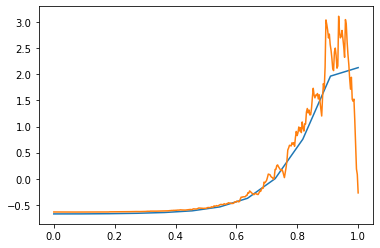

In [18]:
#Calculate Average Inventory
daily_inventory = [0] * 360
monthly_inventory = [0] * 12

for day in range(0, 360):
    month = int(day / 30)
    for sku in range(0, len(df.index)):
        daily_inventory[day] += inventory_level[sku][day] * df.at[sku, 'Std. Price ($)']
        monthly_inventory[month] += inventory_level[sku][day] * df.at[sku, 'Std. Price ($)']

print("Average Daily Inventory is : {} $".format(np.mean(daily_inventory)))
print("Average Monthly Inventory is : {} $".format(np.mean(monthly_inventory)))
plt.plot(np.linspace(0, 1, 12), stats.zscore(np.abs(monthly_inventory)))
plt.plot(np.linspace(0, 1, 360), stats.zscore(np.abs(daily_inventory)))

On average 91 SKUs are placed on order for replenishment.


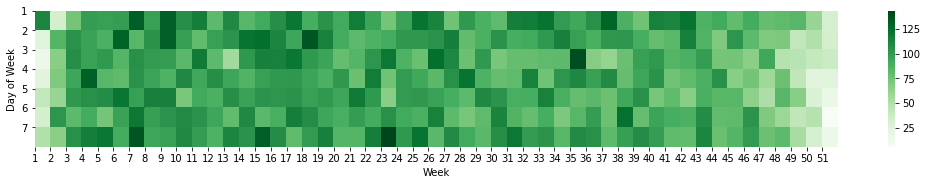

In [19]:
#Order Aggregation
order_aggregation  = np.array(number_of_orders).sum(axis=0)
#print(order_aggregation)

Inputt = iter(order_aggregation) 
Output = [list(islice(Inputt, 7)) for _ in range(int(360/7))] 
#print(Output)

#handling anomaly
Output[0][0] = 112

plt.figure(figsize = (18, 2.5))

#Color Templates - https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
sns.heatmap(np.transpose(Output), cmap="Greens") 

#plt.title('Heatmap of Number of Orders')
plt.xlabel('Week')
plt.ylabel('Day of Week')
plt.yticks(range(0, 7), range(1, np.array(np.transpose(Output)).shape[0] + 1), rotation = 'horizontal')
plt.xticks(range(0, 51), range(1, np.array(np.transpose(Output)).shape[1] + 1), rotation = 'horizontal')

print("On average {} SKUs are placed on order for replenishment.".format(int(np.mean(Output[1:]))))